# Library

In [37]:
#import sys
import pandas as pd
import numpy as np
import random
import pyspark
import itertools
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import pickle
import statsmodels.api as sm

from pyspark import SparkContext, SQLContext

from math import sqrt
from time import time as ttt

from pyspark.sql import SparkSession
from pyspark.sql import functions as f

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier as DTC_spark
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.linear_model import LinearRegression

import joblib
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import parallel_backend


# Upload

In [ ]:
spark = SparkSession.builder.master("Yarn").appName("spark_app_1234").getOrCreate()
sc = spark.sparkContext
spark
d0 = (
    spark
    .read
    .format("csv") 
    .option("header","true") 
    .option("inferSchema","true") 
    .load("gs://mas-a5-storage-1/notebooks/jupyter/application_train.csv")
)

d1 = d0.filter(d0.DAYS_EMPLOYED != 365243).select('TARGET','DAYS_EMPLOYED')

print(d1.rdd.getNumPartitions())

In [ ]:
sc

# Function

In [ ]:
def prepare_spark_data(n_part, k_mult):
    '''
    takes 'DAYS_EMPLOYED and 'TARGET'  from d1 (alreay filtered)
    rearrane in n partitions (if n==0 keeps initial number of partitions)
    prints final shape/ partition
    returns d2 - spark df
    '''
    data = d1
    data_new = data # first step in the cycle
    for i in range(k_mult-1):
        data_tmp = data.select('TARGET', \
                     f.col('DAYS_EMPLOYED')*(f.lit(0.9995) + f.rand()/1000)).\
                   toDF('TARGET','DAYS_EMPLOYED')
        data_tmp = data_tmp.select('TARGET', f.floor('DAYS_EMPLOYED'))
        data_new = data_new.union(data_tmp)

    assembler = VectorAssembler(inputCols=["DAYS_EMPLOYED"], 
                        outputCol="DAYS_EMPLOYED_vect")
    d2 = assembler.transform(data_new)
    if n_part != 0:
        d2 = d2.repartition(n_part, "DAYS_EMPLOYED_vect")       
    #print(f'n-partitions initial: {d2.rdd.getNumPartitions()}; df size: {d2.count()}\n')

    return d2

# Params an run

In [ ]:
## !! mind the fn NOT TO rewrite results
fn = '4cpu_by_12n__4m_yarn_ssd_repart'
size_mult = [1, 2, 5, 10, 15, 20, 30, 50, 100]
partitions = [8, 12, 16, 24, 36, 72] 
# initial, 2**i incl n_nodes till n_cpu*n_nodes and n_cpu*n_nodes
n_iter = 3

print('d1-size', d1.count())
n_part_base = d1.rdd.getNumPartitions()
print('n-partitions initial', n_part_base, '\n')

rd1 = {}
for k_size_mult in size_mult:
    rd2 = {}
    for n_part in partitions:
        df = prepare_spark_data(n_part, k_size_mult)
        df.cache()
        print('======================================================================')
        print(f'=== size_mult={k_size_mult}; \
        n_part_req={n_part}; n_part_act={df.rdd.getNumPartitions()}; df_count={df.count()} ===\n')
        times = [0 for i in range(n_iter)]
        models = {}
        for i in range(n_iter):
            dt = DTC_spark(labelCol="TARGET",
                       featuresCol="DAYS_EMPLOYED_vect",
                       minInfoGain=0.0001,
                       impurity='entropy',
                       maxDepth=14, maxBins=2**14, # it differs from scikit learn - it means number of canidate split points
                       #minInstancesPerNode = 1,
                       #checkpointInterval = 10
                       )
           
            t0 = ttt()
            model = dt.fit(df)
            t1 = ttt()
            times[i] = t1-t0
            models[i] = model 
            print('model', i, 'build time', round(times[i],2), '\n', model)
        rd2[n_part] = (models, times)
    rd1[k_size_mult] = rd2

result = rd1  

# Results

In [ ]:
di = result
df_res_time = pd.DataFrame()
df_res_nodes = pd.DataFrame()
for p1 in di.keys():
    for p2 in di[p1].keys():
        df_res_time.loc[p1, p2] = np.round(np.median(di[p1][p2][1]), 1)
        m_tmp = di[p1][p2][0]
        n_nodes = []
        for i,_ in enumerate(m_tmp):
            tmp = f'{m_tmp[i]}'.split(' ')
            print(i, tmp)
            n_nodes.append([int(x.split('=')[1][:-1]) for x in tmp if x[:4]== 'numN'][0])
        df_res_nodes.loc[p1, p2] = np.round(np.mean(n_nodes), 1)

df_res_time.to_csv(f'gs://mas-a5-storage-1/notebooks/jupyter/obj/{fn}_t.csv')
df_res_nodes.to_csv(f'gs://mas-a5-storage-1/notebooks/jupyter/obj/{fn}_n.csv')

display(df_res_time)      
display(df_res_nodes)     

In [ ]:
#fn = '4cpu_by_8n__4m_yarn_ssd'
tmp = pd.read_csv(f'gs://mas-a5-storage-1/notebooks/jupyter/obj/{fn}_t.csv')
print(fn)
tmp

In [ ]:
#fn = '4cpu_by_8n__4m_yarn_ssd'
tmp = pd.read_csv(f'gs://mas-a5-storage-1/notebooks/jupyter/obj/{fn}_n.csv')
print(fn)
tmp

In [16]:
tmp

,Unnamed: 0,4,8,12,16,24,36
0,1,8.7,10.5,12.9,15.1,20.0,16.1
1,2,6.7,7.9,9.7,8.4,14.3,14.7
2,5,9.0,19.7,7.9,8.0,8.0,8.5
3,10,11.5,8.7,7.1,6.8,7.6,7.5
4,15,14.8,9.4,7.9,6.9,6.4,8.0
5,20,16.8,10.6,9.5,8.8,7.4,8.3
6,30,21.9,14.9,10.8,9.1,9.1,9.2
7,50,30.9,18.8,14.4,12.9,9.3,12.7
8,100,61.5,30.9,22.3,22.5,17.9,21.5


# Analysis

In [25]:
fn = '4cpu_by_12n__4m_yarn_ssd_repart'
tmp = pd.read_csv(f'gcp_obj/notebooks_jupyter_obj_{fn}_t.csv')
print(fn)
tmp1 = tmp.rename(columns={'Unnamed: 0':'size_mult'})
tmp1
t = tmp1.loc[2:, ['size_mult', '8', '12', '24', '36', '72']].set_index('size_mult')
t
#tmp.columns

4cpu_by_12n__4m_yarn_ssd_repart


,8,12,24,36,72
size_mult,,,,,
5,6.6,7.3,7.2,8.7,13.4
10,7.8,7.9,7.3,8.2,11.9
15,9.5,8.1,7.0,8.3,12.7
20,10.4,8.3,7.1,8.3,12.5
30,14.0,10.6,7.8,10.2,13.6
50,17.0,15.8,10.1,10.3,15.7
100,36.3,24.0,18.8,19.5,25.4


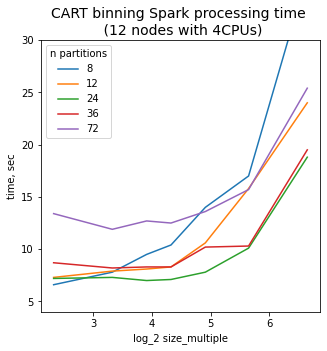

In [36]:
df_tmp = t
plt.figure(figsize=(5,5))
x = np.log2(df_tmp.index.values)
y = df_tmp
plt.ylim([4,30])
plt.xlabel('log_2 size_multiple')
plt.ylabel('time, sec')
plt.title('CART binning Spark processing time \n (12 nodes with 4CPUs)', fontsize = 14)
plt.plot(x, y)
plt.legend(df_tmp.columns.values, title='n partitions')
plt.show()

## Linear regression

In [42]:
df_tmp.index.values

array([  5,  10,  15,  20,  30,  50, 100])

In [51]:
dlm = {}
for i in df_tmp:
    dlm[i] = LinearRegression()
    dlm[i].fit(df_tmp.index.values.reshape(-1,1), df_tmp[i])
    
for i in df_tmp:
    print(dlm[i].intercept_, dlm[i].coef_)

4.431094257854822 [0.30687974]
5.650487540628385 [0.18455038]
5.194907908992414 [0.12580715]
6.652546045503793 [0.11709642]
10.528602383531961 [0.13695558]


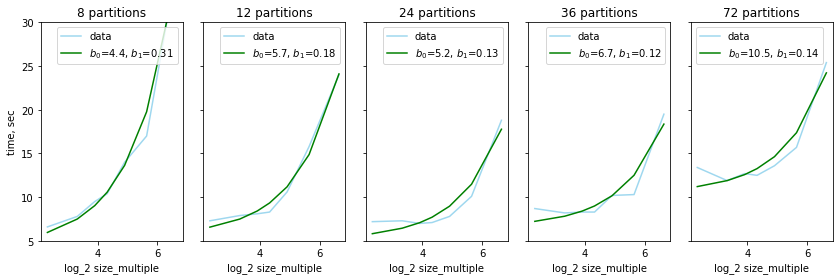

In [127]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))  # define the figure and subplots
axes = axes.ravel()  # array to 1D
cols = df_tmp.columns  # create a list of dataframe columns to use
#colors = ['tab:blue', 'tab:orange', 'tab:green']  # list of colors for each subplot, otherwise all subplots will be one color
#fig.suptitle('CART binning Spark processing time (12 nodes with 4CPUs)')

for col, ax in zip(cols, axes):
    x = np.log2(df_tmp.index.values)
    y = df_tmp[col]
    y1 = [(dlm[col].intercept_ + x * dlm[col].coef_) for x in df_tmp.index.values]
    #ax.ylim([4,30])
    #ax.title('CART binning Spark processing time \n (12 nodes with 4CPUs)', fontsize = 14)
    ax.plot(x, y, label = f'data', alpha = 0.8, color='skyblue')
    ax.plot(x, y1, label = f'$b_0$={dlm[col].intercept_:.1f}, $b_1$={dlm[col].coef_[0]:.2f}', color = 'g')
    ax.set(xlabel ='log_2 size_multiple', ylabel='time, sec')
    ax.set_title(f'{col} partitions')
    ax.legend()
    ax.set_ylim([5,30])
    ax.label_outer()

fig.tight_layout()
plt.show()